In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary

import matplotlib.pyplot as plt

from typing import Optional, Sequence, Tuple, List

# Set device for GPU

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Create Gaussian blurs with different widths

In [3]:
nPerClass = 1000
imgSize   = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# the two widths (a.u.)
widths = [1.8,2.4]

# initialize tensors containing images and labels
images = torch.zeros(2*nPerClass,1,imgSize,imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):

  # create the gaussian with random centers
  ro = 2*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2) )

  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5

  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
  labels[i] = i%2

labels = labels[:,None]

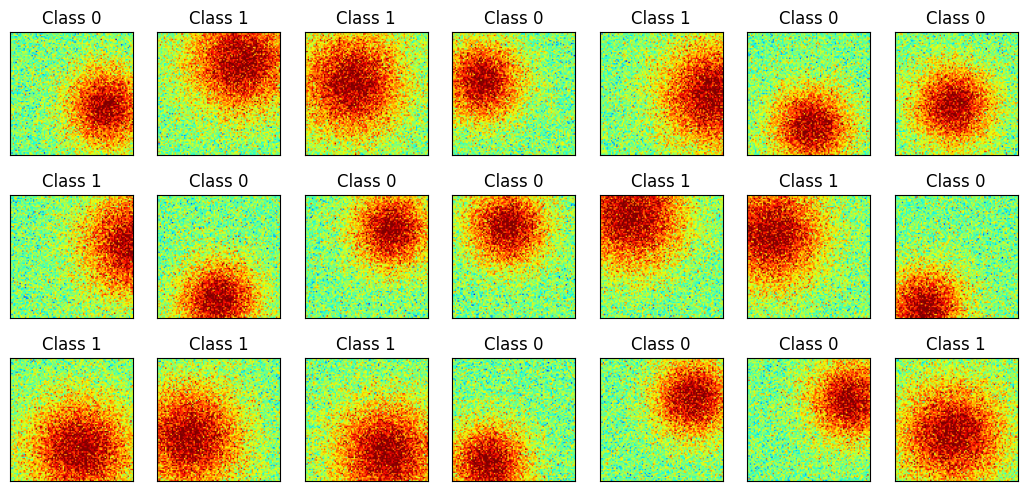

In [4]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(2*nPerClass)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_title('Class %s'%int(labels[whichpic].item()))
  ax.set_xticks([])
  ax.set_yticks([])

plt.show();

# Create train/test groups using DataLoader

In [5]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [6]:
# check size (should be images X channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

torch.Size([1800, 1, 91, 91])
torch.Size([1800, 1])


# Create the DL model

In [7]:
# Helper functions

def _pair(x):
  return x if isinstance(x,(tuple,list)) else (x,x)

def conv2d_out_hw(HW, kernel_size, stride, padding, dilation):
    H, W = HW
    kH, kW = _pair(kernel_size)
    sH, sW = _pair(stride)
    pH, pW = _pair(padding)
    dH, dW = _pair(dilation)
    outH = np.floor((H + 2*pH - dH*(kH-1) - 1)/sH + 1)
    outW = np.floor((W + 2*pW - dW*(kW-1) - 1)/sW + 1)
    return int(outH), int(outW)

In [8]:
# define the model architecture
class CNNnet(nn.Module):
    def __init__(
        self,
        imgSize: Tuple[int, int],           #H,W
        in_channels: int,
        out_channels: Sequence[int],         #conv1, conv2
        kernel_size: int | Tuple[int, int]=3,
        stride: int | Tuple[int, int]=1,
        padding: Optional[int | Tuple[int, int]]=0,
        pool_size: Optional[Tuple[int, int]]=(2,2),
        dilation: int | Tuple[int, int]=1,
        groups: int =1,
        bias: bool =True,
        padding_mode: str='zeros',

        # Defintions for the ANN model
        uLinear: Optional[Sequence[int]] = None,
        out_size: int = 1,

        device=None,
        dtype=None,
        print_shapes: bool = False
      ):
      super().__init__()
      assert len(out_channels) >= 2, 'Invalid number of channels'

      factory = dict(device=device, dtype=dtype) # Setting the device and dtype

      self.pool = nn.AvgPool2d(pool_size)

      poolH, poolW = _pair(pool_size)

      # conv1 Layer
      self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels[0],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias,
            padding_mode=padding_mode,
            **factory
        )

      H1, W1 = conv2d_out_hw(imgSize, kernel_size, stride, padding, dilation)
      H1p, W1p = H1 //poolH , W1 // poolW  # avg pool


      # conv2 Layer
      self.conv2 = nn.Conv2d(
            in_channels=out_channels[0],
            out_channels=out_channels[1],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias,
            padding_mode=padding_mode,
            **factory
        )

      H2, W2 = conv2d_out_hw((H1p,W1p), kernel_size, stride, padding, dilation)
      H2p, W2p = H2 // poolH, W2 // poolW  # avg pool

      flat = int(self.conv2.out_channels * H2p * W2p)
      if flat <= 0: raise ValueError(f"Flattened size {flat} is non-positive. Check imgSize/conv params.")

      # --- Multi-Layer Perceptorn (MLP) (variable depth) ---
      sizes = list(uLinear) if uLinear is not None else [50]
      self.fcs = nn.ModuleList()
      prev = flat
      for h in sizes:
          self.fcs.append(nn.Linear(prev, h, **factory))
          prev = h
      self.output_layer = nn.Linear(prev, out_size, **factory)

      # ----- optional shape printout & probe -----
      if print_shapes:
          C0 = in_channels
          C1 = self.conv1.out_channels
          C2 = self.conv2.out_channels
          print("[gausnet] (math) shapes:")
          print(f"  Input      : (C,H,W)=({C0},{imgSize[0]},{imgSize[1]})")
          print(f"  Conv1 out  : (C,H,W)=({C1},{H1},{W1})")
          print(f"  Pool1 out  : (C,H,W)=({C1},{H1p},{W1p})")
          print(f"  Conv2 out  : (C,H,W)=({C2},{H2},{W2})")
          print(f"  Pool2 out  : (C,H,W)=({C2},{H2p},{W2p})")
          print(f"  Flatten    : {flat}")
          print(f"  MLP sizes  : {sizes} -> out_size={out_size}")

            # Probe with a dummy forward to verify
          with torch.no_grad():
              dummy = torch.zeros(1, C0, imgSize[0], imgSize[1], device=device, dtype=dtype)
              a1 = F.relu(self.conv1(dummy))
              p1 = self.pool(a1)
              a2 = F.relu(self.conv2(p1))
              p2 = self.pool(a2)
              probe_flat = p2.flatten(1).shape[1]

          print("[gausnet] (probe) shapes:")
          print(f"  Conv1 out  : {tuple(a1.shape[1:])}")
          print(f"  Pool1 out  : {tuple(p1.shape[1:])}")
          print(f"  Conv2 out  : {tuple(a2.shape[1:])}")
          print(f"  Pool2 out  : {tuple(p2.shape[1:])}")
          print(f"  Flatten    : {probe_flat}")
          if probe_flat != flat:
              print("[gausnet][WARN] math(flat) != probe(flat) → check conv/pool params!")


    def forward(self,x):
      # first conv-pool set
      conv1act = F.relu(self.conv1(x))
      x = self.pool(conv1act)

      # second conv-pool set
      conv2act = F.relu(self.conv2(x))
      x = self.pool(conv2act)

      # Fully Connected part
      x = x.reshape(x.shape[0],-1)
      for fc in self.fcs:
            x = F.relu(fc(x))
      logits = self.output_layer(x)

      return logits

In [9]:
# function to instaniate and create the model
def makeTheNet(
    imgSize: Tuple[int, int],
    in_channels: int,
    out_channels: Sequence[int],
    kernel_size: int | Tuple[int, int],
    stride: int | Tuple[int, int] = 1,
    padding: int | Tuple[int, int] = 0,
    pool_size: Optional[Tuple[int,int]] = (2,2),
    dilation: int | Tuple[int, int] = 1,
    groups: int = 1,
    bias: bool = True,
    padding_mode: str = 'zeros',
    uLinear: Optional[Sequence[int]] = None,
    out_size: int = 1,
    device=None,
    dtype=None,
    print_shapes: bool = False
):
    net = CNNnet(
        imgSize=imgSize,
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=padding,
        pool_size=pool_size,
        dilation=dilation,
        groups=groups,
        bias=bias,
        padding_mode=padding_mode,
        uLinear=uLinear,
        out_size=out_size,
        device=device,
        dtype=dtype,
        print_shapes=print_shapes
    )
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    return net, lossfun, optimizer

In [10]:
# count the total number of parameters in the model
net,lossfun,optimizer = makeTheNet(
    imgSize=(images.shape[2],images.shape[3]),
    in_channels=1,
    out_channels=[16,32],
    kernel_size=3,
    stride=1,
    padding=0,
    pool_size=(2,2),
    uLinear=[50],
    out_size=1
)
net.to(device) # Move the model to the GPU
summary(net,(images.shape[1],images.shape[2],images.shape[3]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 89, 89]             160
         AvgPool2d-2           [-1, 16, 44, 44]               0
            Conv2d-3           [-1, 32, 42, 42]           4,640
         AvgPool2d-4           [-1, 32, 21, 21]               0
            Linear-5                   [-1, 50]         705,650
            Linear-6                    [-1, 1]              51
Total params: 710,501
Trainable params: 710,501
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.74
Params size (MB): 2.71
Estimated Total Size (MB): 4.48
----------------------------------------------------------------


# Train the model

In [11]:
X, y = next(iter(train_loader))
print(X.shape)
print(y.shape)

torch.Size([32, 1, 91, 91])
torch.Size([32, 1])


In [12]:
def trainCNNmodel(
    numepochs=10,
    imgSize=(images.shape[2],images.shape[3]),
    in_channels=1,
    out_channels=[16,32],
    kernel_size = 3,
    stride = 1,
    padding = 0,
    pool_size = (2,2),
    uLinear = [50],
    out_size = 1,
    print_shapes = False
):
  net, lossfun, optimizer = makeTheNet(
      imgSize=imgSize,
      in_channels=in_channels,
      out_channels=out_channels,
      kernel_size = kernel_size,
      stride = stride,
      padding = padding,
      pool_size=pool_size,
      uLinear=uLinear,
      out_size=out_size,
      print_shapes=print_shapes
  )

  net.to(device) #Move the model to GPU

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  testAcc   = torch.zeros(numepochs)

  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X) # Removed [0] here

      yHat = yHat.cpu() # Move back to CPU
      y = y.cpu()       # Move back to CPU

      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean(( (yHat>0) ==y).float()).item() )
    # end of batch loop...

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad(): # deactivates autograd
      yHat = net(X) # Removed [0] here
      yHat = yHat.cpu() # Move back to CPU
      y = y.cpu()       # Move back to CPU

      loss = lossfun(yHat,y) # Unsqueeze y to match yHat shape

    # compare the following really long line of code to the training accuracy lines
    testLoss[epochi] = loss.item()
    testAcc[epochi]  = 100*torch.mean(( (yHat>0) ==y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainAcc,testAcc,net

# Run the model

In [13]:
from tqdm import tqdm

numepochs = 10
feature_maps = (3,6)
kernel_size = (3,2)
stride = (2,3)

fc1_units = np.linspace(5,500,20).astype(int)
fc2_units = np.linspace(5,500,20).astype(int)

train_losses = np.zeros(len(fc2_units))
test_losses  = np.zeros(len(fc2_units))
train_accs   = np.zeros(len(fc2_units))
test_accs    = np.zeros(len(fc2_units))

for i, (fc1i, fc2i) in enumerate(tqdm(zip(fc1_units, fc2_units),
                                      total=len(fc2_units),
                                      desc="Sweeping fc2 units")):
    uLinear = [int(fc1i), int(fc2i)]
    trainLoss, testLoss, trainAcc, testAcc, net = trainCNNmodel(
        numepochs=numepochs,
        imgSize=(images.shape[2], images.shape[3]),
        in_channels=1,
        out_channels=feature_maps,
        kernel_size=kernel_size,
        stride=stride,
        uLinear=uLinear,
        out_size=1,
        print_shapes=False
    )

    # store only the final epoch's values (ensure they are scalars)
    train_losses[i] = float(trainLoss[-1])
    test_losses[i]  = float(testLoss[-1])
    train_accs[i]   = float(trainAcc[-1])
    test_accs[i]    = float(testAcc[-1])

Sweeping fc2 units:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Sweeping fc2 units: 100%|██████████| 20/20 [00:40<00:00,  2.01s/it]


# Visualize the Results

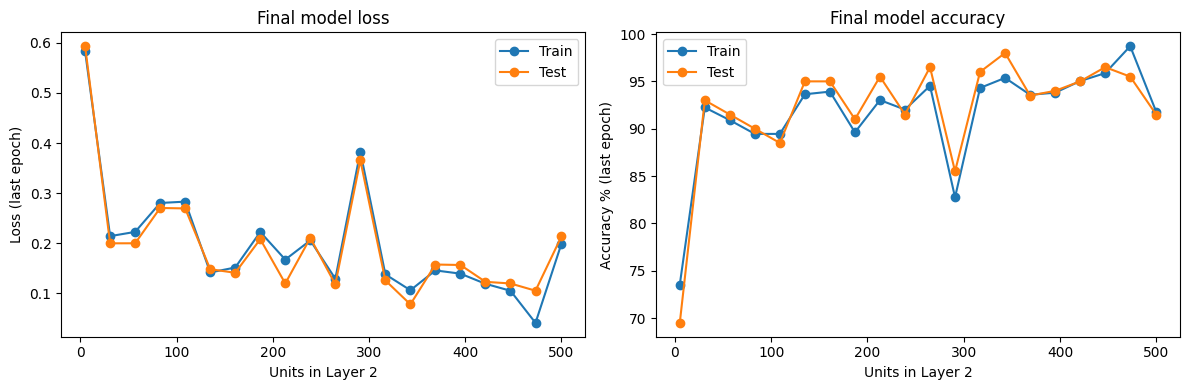

In [14]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(fc2_units, train_losses, marker='o', label='Train')
ax[0].plot(fc2_units, test_losses,  marker='o', label='Test')
ax[0].set_xlabel('Units in Layer 2')
ax[0].set_ylabel('Loss (last epoch)')
ax[0].set_title('Final model loss')
ax[0].legend()

ax[1].plot(fc2_units, train_accs, marker='o', label='Train')
ax[1].plot(fc2_units, test_accs,  marker='o', label='Test')
ax[1].set_xlabel('Units in Layer 2')
ax[1].set_ylabel('Accuracy % (last epoch)')
ax[1].set_title('Final model accuracy')
ax[1].legend()

plt.tight_layout()
plt.show();

# Save the model

In [17]:
torch.save(net.state_dict(), '/content/drive/MyDrive/Colab Notebooks/gausnet.pth')